# Proyecto Final

In [4]:
library(forecast)
library(tseries)
library(zoo)
library(Metrics)

options(warn = -1)

## 1. Explicación de los datos, su origen e interés de su estudio.

Los datos con los que trataremos para este proyecto están recogidos del este [link](https://www.epdata.es/datos/gripe-hoy-estadisticas-datos-casos-comunidad-autonoma/203/cataluna/297?accion=2).

Se trata de una serie temporal sobre la tasa de contagios de gripe en Cataluña por 100.000 habitantes que va desde la semana 40 de 2015 hasta la tercera de 2019 aunque para mayor facilidad a la hora de comprender estos en el análisis exploratorio decidimos tratar solo con los datos desde el inicio de 2016 hasta final de 2018. Otro cambio que tuvimos que realizarle a los datos originales fue añadirle varias semanas con un valor de 0, ya que en los datos originales no se recogen los contagios de mayo a septiembre, es decir, en verano. Esto tiene bastante sentido, ya que los contagios por gripe en verano se podrían negligir perfectamente, ya que son mínimos y no debe salir a cuenta llevar un registro tan minoritario.

Nos ha interesado esta serie temporal por varias razones, la primera es que queríamos saber si se apreciaba una tendencia en cuanto a los contagios por gripe a través de los años o si estos eran relativamente estables, además, estos datos son un claro ejemplo de una serie temporal con las características que hemos estado viendo en clase cosa que nos ayudará en el proyecto y a entender mejor los conceptos del curso.

## 2. Análisis exploratorio de los datos.

In [5]:
gripe_2016_2018 = read.csv("gripe.csv", header=TRUE, sep=";", dec=",")
data = read.csv("gripe.csv", header=TRUE, sep=";", dec=",")

head(gripe_2016_2018)

,Año,Periodo,Gripe
,<int>,<chr>,<dbl>
1,2016,Semana 1,17.60
2,2016,Semana 2,47.41
3,2016,Semana 3,83.59
4,2016,Semana 4,190.14
5,2016,Semana 5,187.42
6,2016,Semana 6,262.18


### Serie Temporal de la Gripe

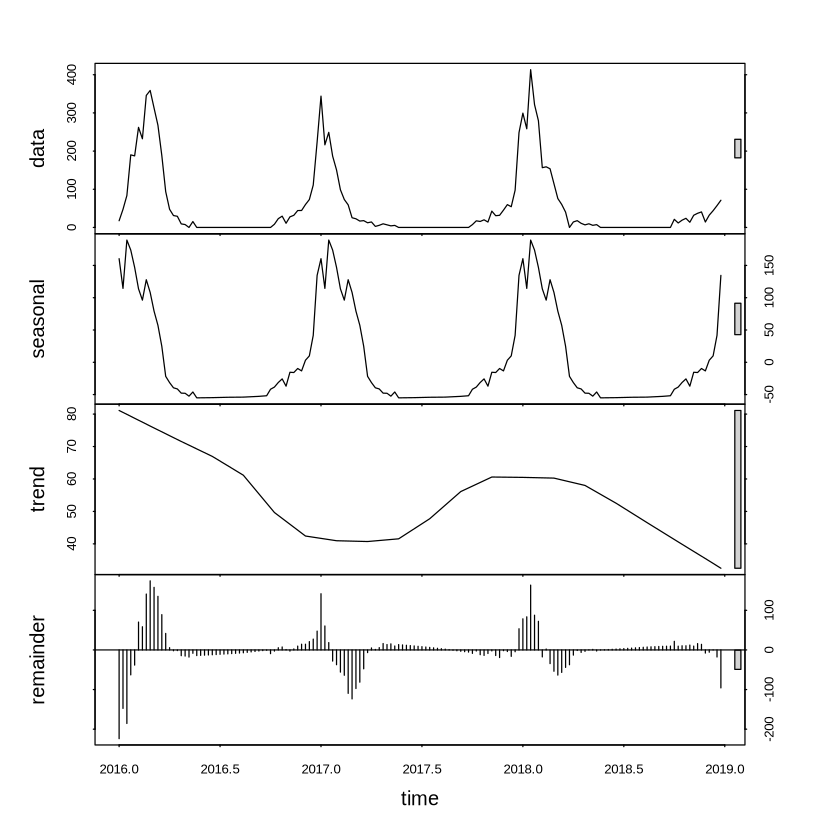

In [6]:
gripe_temporal <- ts(gripe_2016_2018$Gripe, start=c(2016, 1), frequency=52)
plot(stl(gripe_temporal, s.window="periodic"))

* **DATA**: La primera gráfica muestra la serie temporal original, esta muestra la cantidad de contagios por cada 100.000 habitantes en Cataluña, a lo largo de 2016 - 2018. Se puede observar que hay picos recurrentes en ciertos periodos del año, lo cual nos indica una posible estacionalidad en los datos.

* **Seasonal**: En este gráfico se encuentran los patrones recurrentes que se repiten a lo largo de cada año. Se puede ver claramente que la estacionalidad es muy pronunciada, hay picos que ocurren de manera regular cada año, lo cual nos da un indicio que la gripe suele aumentar en ciertos periodos de año (invierno) y disminuye en otros (verano)

* **Trend**: En este gráfico se muestra la tendencia a lo largo del los años. Se puede ver de forma clara como hay un descenso gradual en el número de contagios de gripe desde 2016 hasta mediados de 2017, seguido por un aumento hasta finales de 2018 y una posterior disminución. Esta gráfica nos da a entender que no hay una tendencia clara en los datos.

* **Remainder**: Este gráfico muestra el componente residual, que es lo que no se llega a explicar ni por estacionalidad, ni por tendencia. 

## Funciones generales

#### Gráficos

In [7]:
bilined_graph <- function(y_og_data, y_op_data, graph_title = "",  x_label = "X", y_label = "Y", legend_position, legend = "Xt", legend1 = "X1", x_xmuestral) {
    
    plot(y_og_data, type = "l", xlab = x_label, ylab = y_label, main = graph_title)
    lines(y_op_data, type = "l", col = "red")

    legend(legend_position,           
       legend = c(legend, legend1), 
       col = c("black", "red"),  
       lty = 1,  
       cex = 0.6) 

    abline(v = x_xmuestral, col = "blue", lty = 2)
}   

#### Errores

In [8]:
errores <- function(og_data, pred_data) {
    print(paste("Error Medio Absoluto: ", mae(og_data, pred_data)))
    print(paste("Error Medio Cuadratico: ", mse(og_data, pred_data)))
}

## 3. Aplicación de modelos deterministas.

Después de analizar previamente la serie temporal de los contagios de gripe, hemos concluido que esta tiene una clara estacionalidad y no tiene tendencia, por lo tanto, es una serie temporal Tipo II.

### Método Ingenuo Estacional & Método de las Medias Estacionales

#### Cálculo

In [9]:
# Ingenuo Estacional
data$Ingenuo <- data$Gripe
for (x in 1:52) {
    data$Ingenuo[x] = NA
}
for (x in 53:156) {
    data$Ingenuo[x] <- data$Gripe[x -52]
}

In [10]:
# Medias Estacionales
data$Medias <- data$Gripe
medias <- c()

for (i in 1:52) {
    media <- mean(subset(data[1:104,], Periodo == data$Periodo[i])$Gripe)
    medias <- c(medias, media)
}

for (i in 1:156) {
    if (i%%52 != 0) {
        data$Medias[i] <- medias[i%%52]
    } else {
        data$Medias[i] <- medias[52]
    }
}

#### Gráficos

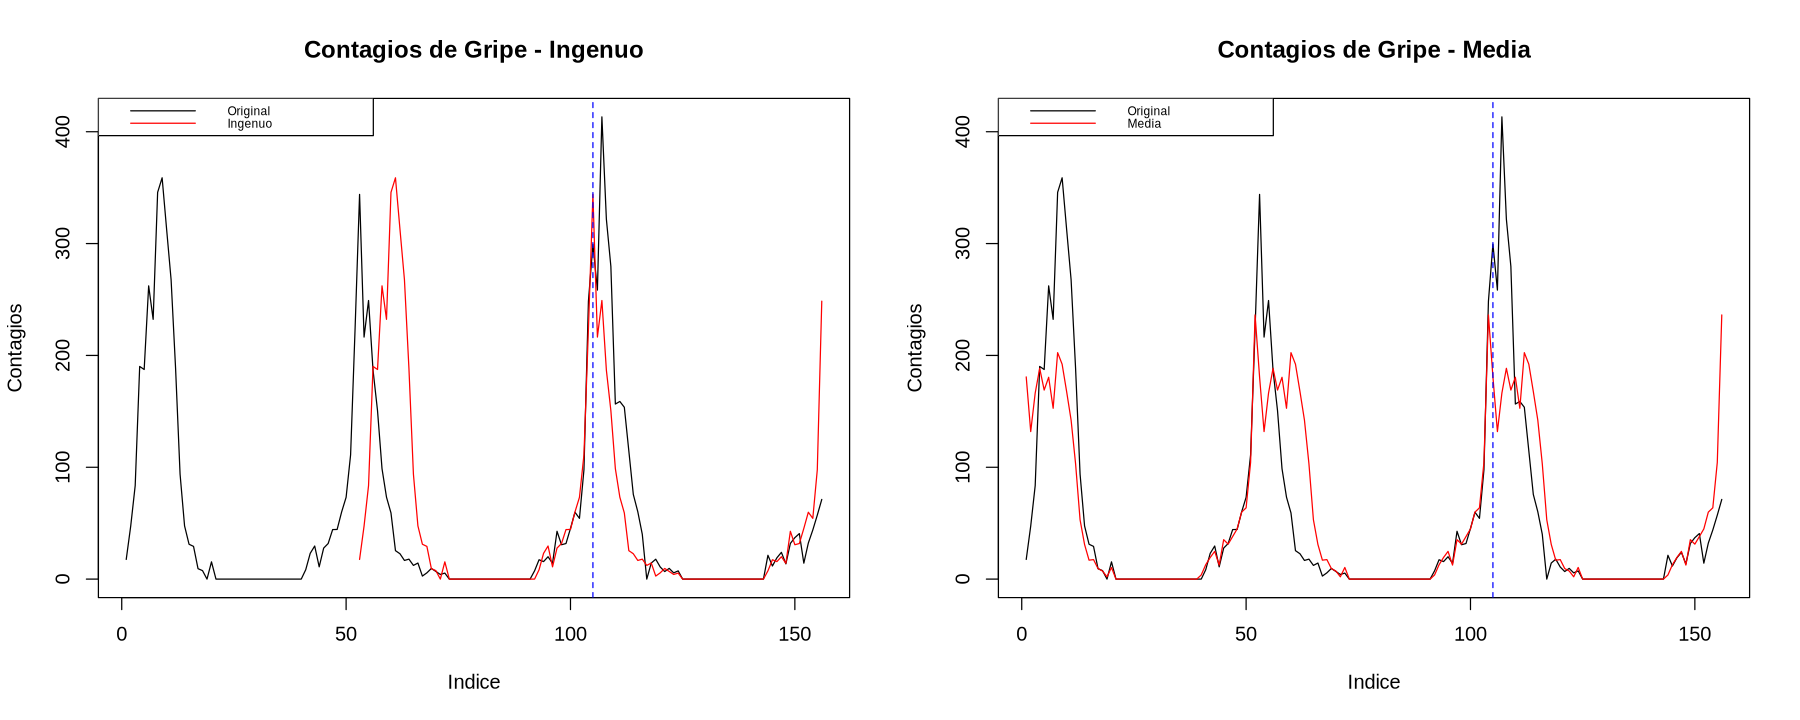

In [11]:
old_par <- par()
par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=6)
bilined_graph(data$Gripe, data$Ingenuo, "Contagios de Gripe - Ingenuo", "Indice", "Contagios","topleft", "Original", "Ingenuo", which(data$Año == 2018)[1])

bilined_graph(data$Gripe, data$Medias, "Contagios de Gripe - Media", "Indice", "Contagios","topleft", "Original", "Media", which(data$Año == 2018)[1])

par(old_par)

#### Calcular ECM & EAM de Periodo Extra-Muestral

##### Ingenuo

In [12]:
errores(data$Gripe[105:156], data$Ingenuo[105:156])

[1] "Error Medio Absoluto:  25.8111538461538"
[1] "Error Medio Cuadratico:  2579.25846538462"


##### Medias Estacionales

In [13]:
errores(data$Gripe[105:156], data$Medias[105:156])

[1] "Error Medio Absoluto:  29.6302884615385"
[1] "Error Medio Cuadratico:  3543.13508798077"


## 4. Aplicación de modelos estocásticos.

### Modelo Autoregresivo de Media Móvil

In [14]:
gripe_t_data <- window(gripe_temporal, end=c(2017, 52))

#### Función de Autocorrelación & Función Parcial de Autocorrelación

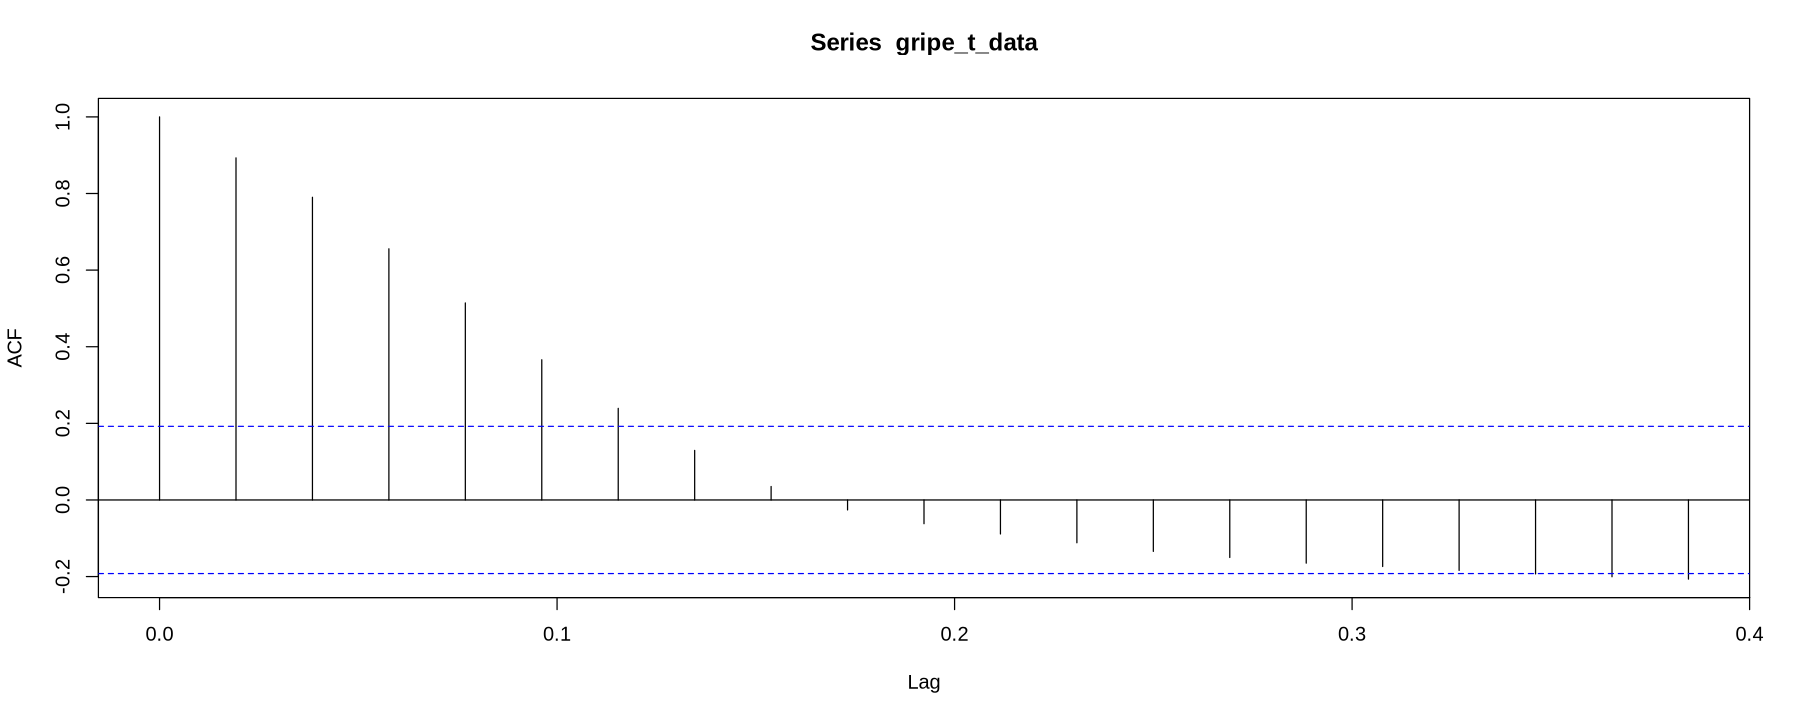

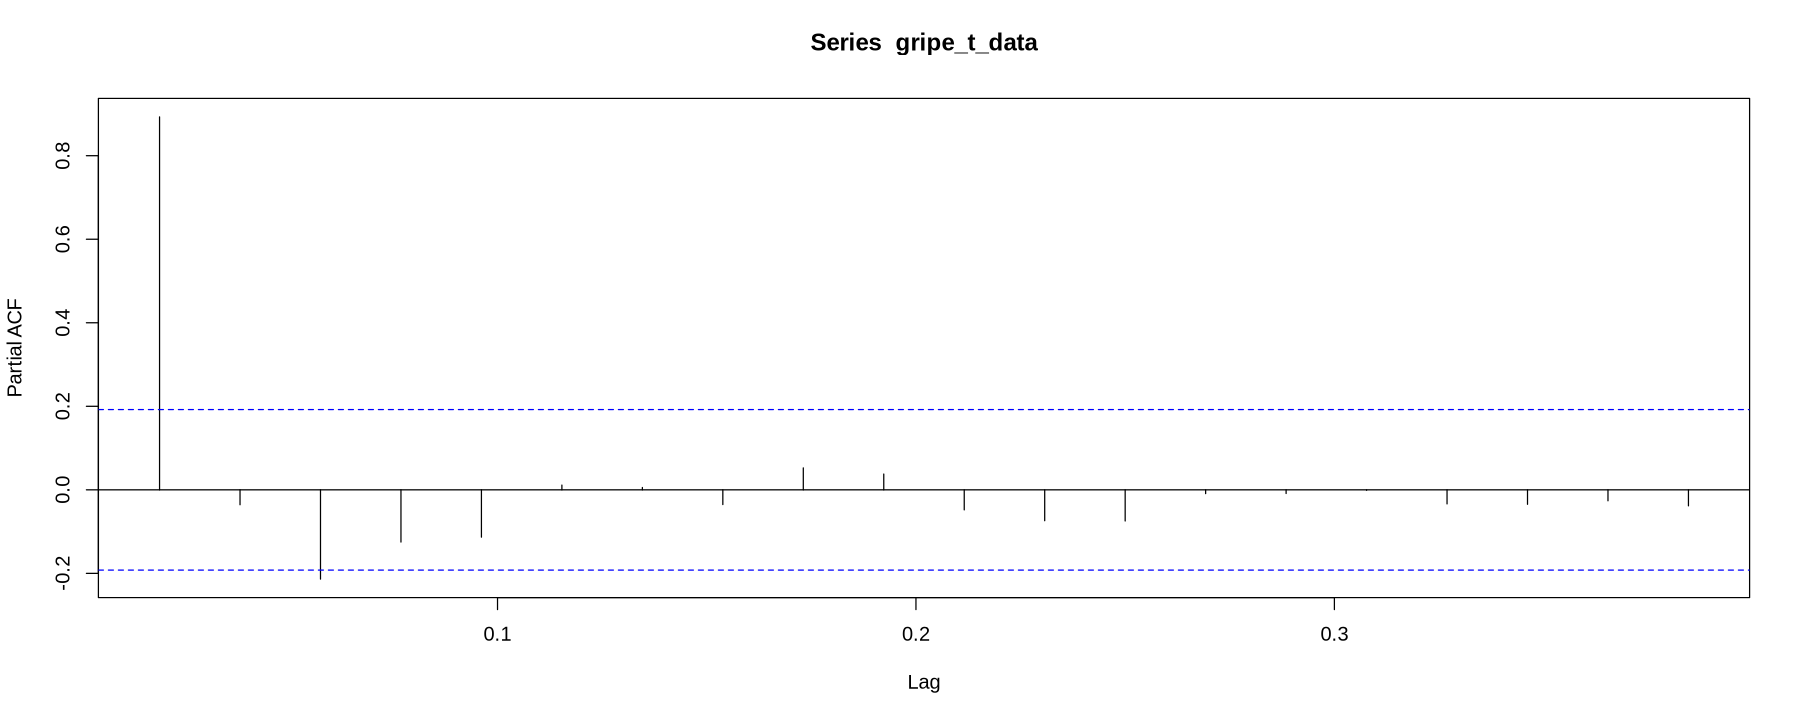

In [15]:
acf(gripe_t_data) 
pacf(gripe_t_data)

**ACF**: Podemos observar una disminución gradual de los valores.

**PACF**: Podemos observar que tanto el primer como el tercer valor superan el límite de significancia estadística.

Dado que se observa un decremento gradual de los valores en el ACF y que tanto el primero valor como el tercero son significativos en el ACF, hemos deducido que el modelo correcto para estos datos es un AR(3).

#### Modelo AR(3)

         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
2018.000      274.69136 232.14346 317.2393  209.61996 339.7628
2018.019      307.45273 244.15594 370.7495  210.64865 404.2568
2018.038      294.79038 209.65279 379.9280  164.58367 424.9971
2018.058      275.90790 175.14321 376.6726  121.80161 430.0142
2018.077      242.22691 129.59473 354.8591   69.97086 414.4830
2018.096      207.13550  86.74077 327.5302   23.00765 391.2633
2018.115      170.78504  45.53128 296.0388  -20.77405 362.3441
2018.135      137.97554  10.04861 265.9025  -57.67182 333.6229
2018.154      109.39512 -19.83492 238.6252  -88.24517 307.0354
2018.173       86.34984 -43.39090 216.0906 -112.07149 284.7712
2018.192       68.70875 -61.16989 198.5874 -129.92348 267.3410
2018.212       56.25363 -73.63633 186.1436 -142.39592 254.9032
2018.231       48.27727 -81.61949 178.1740 -150.38268 246.9372
2018.250       44.01863 -85.92038 173.9576 -154.70594 242.7432
2018.269       42.62628 -87.38745 172.6400 -156.21256 2

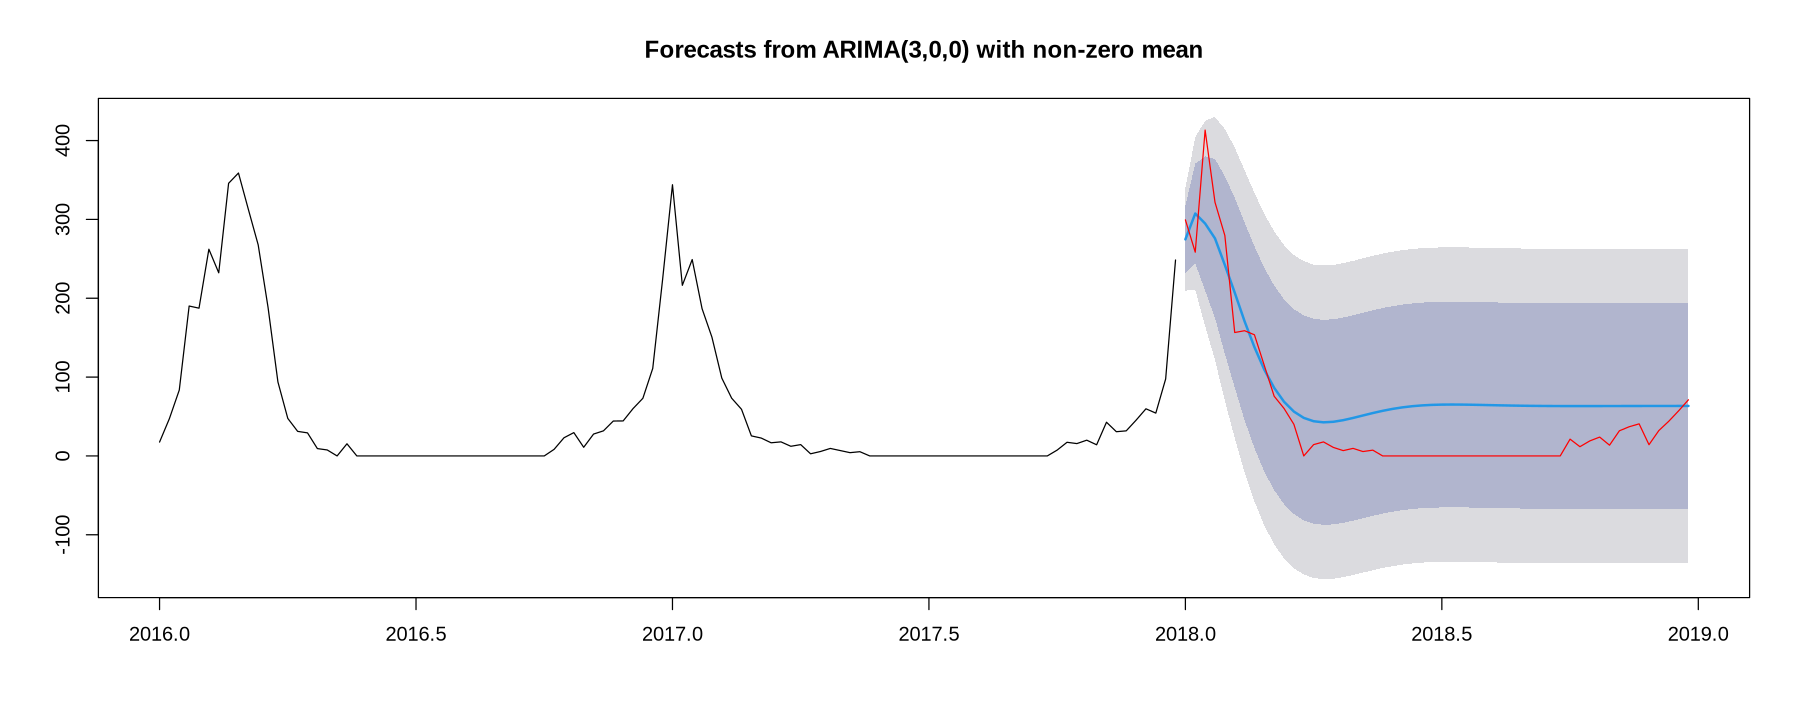

In [16]:
modelo <- arima(gripe_t_data,order=c(3,0,0))

forecast_ar <- forecast(modelo, h=52)

print(forecast_ar)

plot(forecast_ar)
og_ar_data <- window(gripe_temporal, start=c(2018, 1))
lines(og_ar_data, col='red')

#### Calcular ECM & EAM de Periodo Extra-Muestral

In [17]:
errores(og_ar_data, forecast_ar$mean)

[1] "Error Medio Absoluto:  44.7195409788952"
[1] "Error Medio Cuadratico:  2482.58543604454"


### Modelo Autoregresivo Integrado de Media Móvil

#### Modelo ARIMA(4,0,2)

         Point Forecast      Lo 80    Hi 80      Lo 95    Hi 95
2018.000    267.9846805  224.17826 311.7911  200.98853 334.9808
2018.019    295.4438526  231.47408 359.4136  197.61053 393.2772
2018.038    289.1736780  204.83115 373.5162  160.18291 418.1644
2018.058    277.2826639  177.54591 377.0194  124.74846 429.8169
2018.077    248.4055819  136.20327 360.6079   76.80695 420.0042
2018.096    215.9445321   95.18262 336.7064   31.25513 400.6339
2018.115    177.4522227   51.00645 303.8980  -15.92989 370.8343
2018.135    139.8806583   10.26944 269.4919  -58.34259 338.1039
2018.154    103.4173337  -27.69555 234.5302  -97.10252 303.9372
2018.173     71.5415878  -60.04505 203.1282 -129.70281 272.7860
2018.192     44.6313229  -87.00517 176.2678 -156.68932 245.9520
2018.212     24.0223352 -107.64483 155.6895 -177.34521 225.3899
2018.231      9.5341112 -122.36517 141.4334 -192.18843 211.2566
2018.250      1.1600317 -131.23081 133.5509 -201.31429 203.6344
2018.269     -1.8428914 -134.92285 131.2

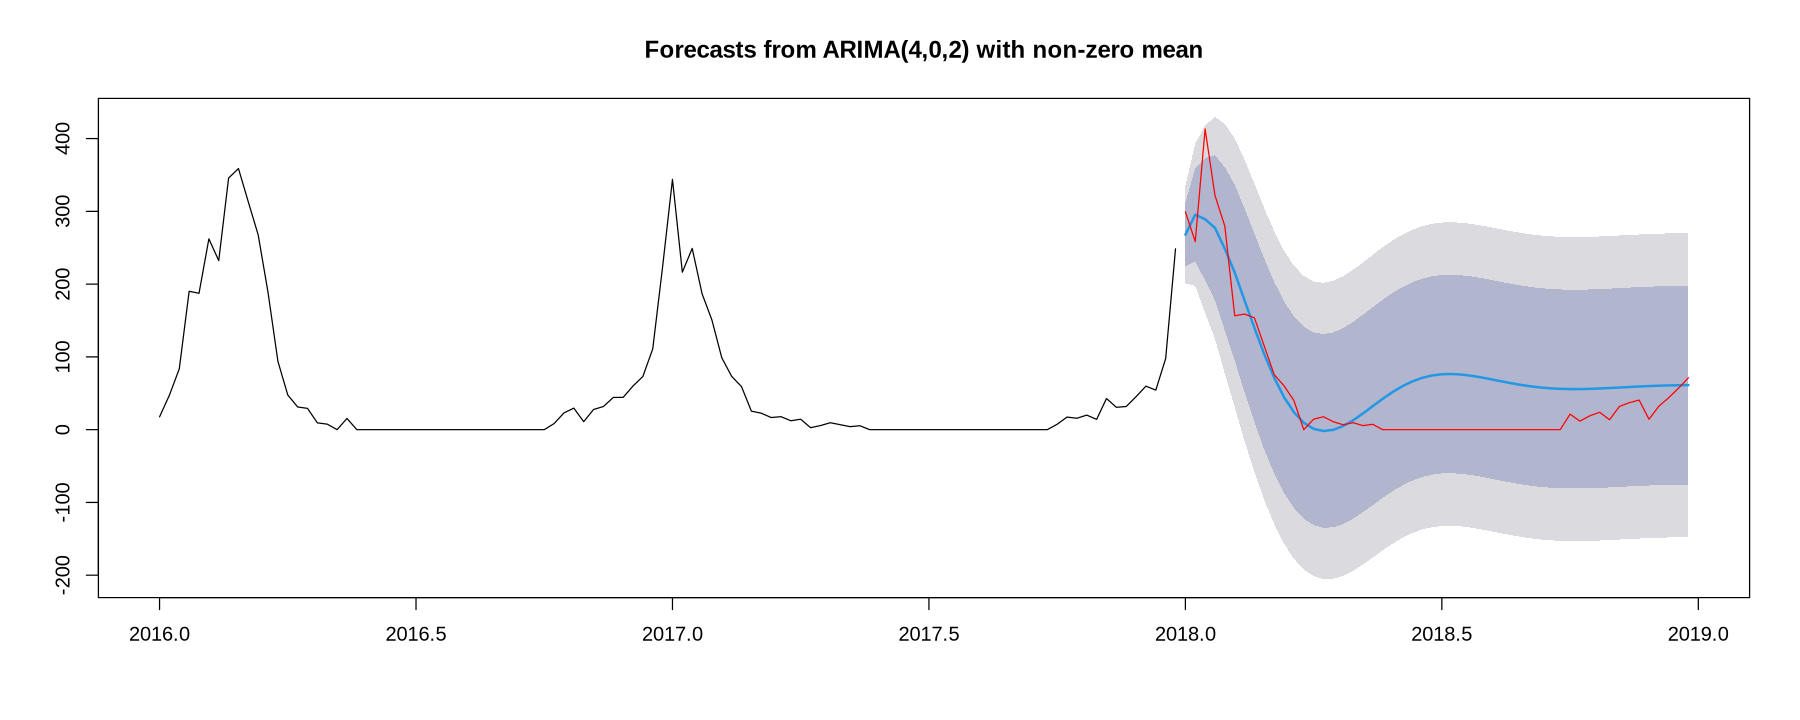

In [18]:
fit <- auto.arima(gripe_t_data)

# Realizar la predicción para 2023
forecast_arima <- forecast(fit, h=52)

# Mostrar la predicción
print(forecast_arima)

# Graficar los resultados
plot(forecast_arima)
og_arima_data <- window(gripe_temporal, start=c(2018, 1))
lines(og_arima_data, col='red')

#### Calcular ECM & EAM de Periodo Extra-Muestral

In [19]:
errores(og_arima_data, forecast_arima$mean)

[1] "Error Medio Absoluto:  40.4106394383008"
[1] "Error Medio Cuadratico:  2322.47199498468"


## 5. Aplicación de modelos avanzados de predicción. 

In [20]:
#install.packages("prophet")
library(prophet)
#install.packages("tidyverse")
library(tidyverse)
#install.packages("lubridate")
library(lubridate)

### Prophet

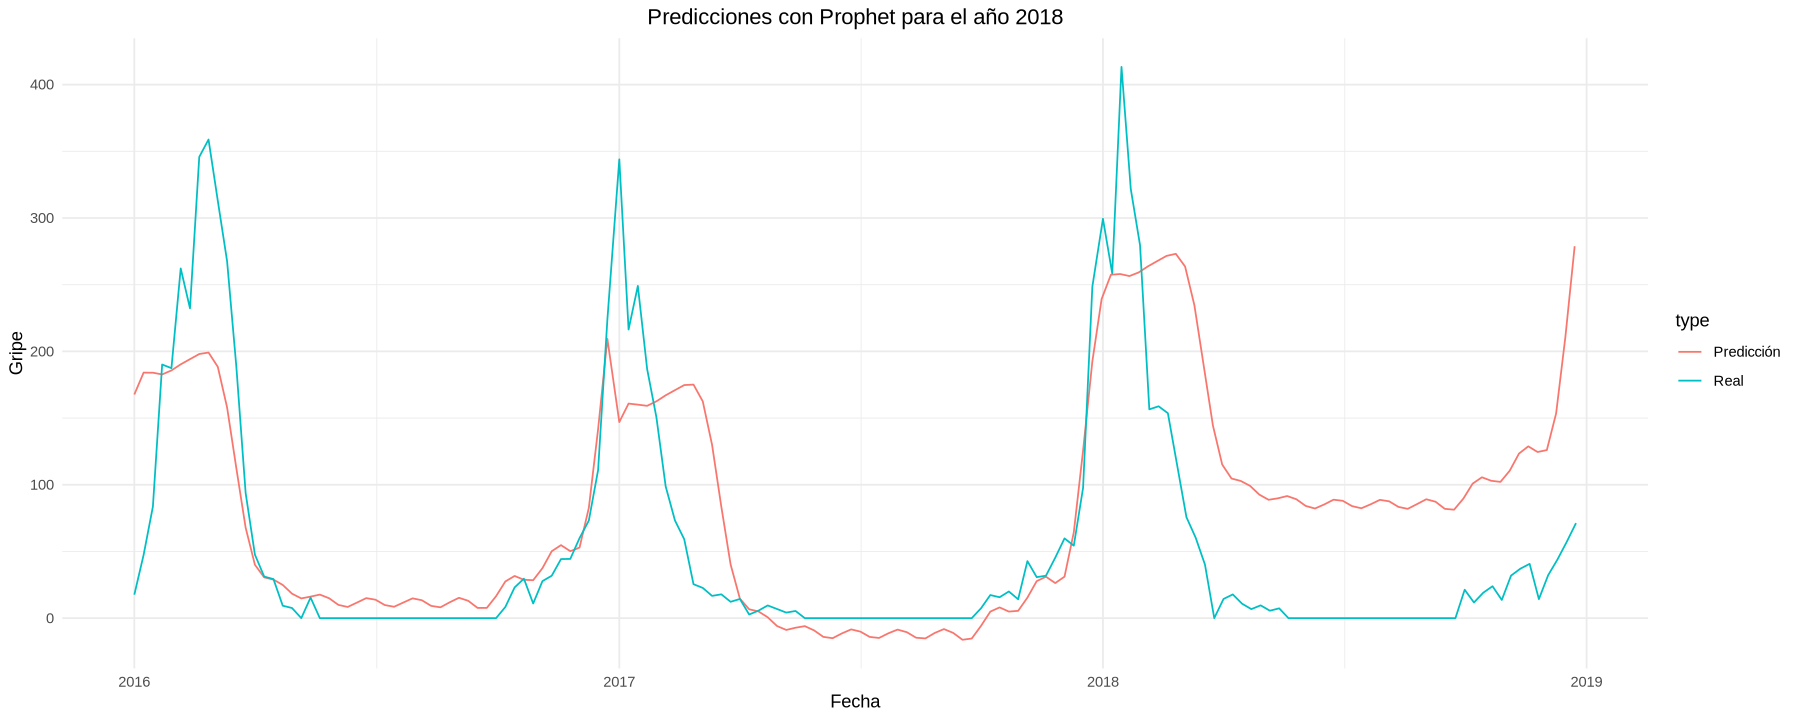

In [21]:
datatt <- data %>%
  mutate(
    week = as.numeric(sub("Semana ", "", Periodo)),
    ds = ymd(paste0(Año, "-01-01")) + weeks(week - 1)
  ) %>%
  select(ds, y = Gripe)

# Separar los datos en entrenamiento (hasta 2017) y prueba (2018)
train_data <- datatt %>% filter(ds < "2018-01-01")
test_data <- datatt %>% filter(ds >= "2018-01-01")

# Ajustar el modelo Prophet con los datos de entrenamiento
fit_prophet <- prophet(train_data, yearly.seasonality = TRUE, weekly.seasonality = TRUE, daily.seasonality = FALSE)

# Crear un dataframe de futuras fechas para las predicciones
future <- make_future_dataframe(fit_prophet, periods = 52, freq = "week")

# Hacer predicciones
forecast_prophet <- predict(fit_prophet, future)

# Combinar los datos de predicción y los datos reales en un solo dataframe
forecast_prophet <- forecast_prophet %>%
  select(ds, yhat) %>%
  mutate(type = "Predicción")

datatt <- datatt %>%
  rename(yhat = y) %>%
  mutate(type = "Real")

combined_data <- bind_rows(forecast_prophet, datatt)

# Crear un gráfico de predicciones con los valores reales usando ggplot2
ggplot(combined_data, aes(x = ds, y = yhat, color = type)) +
  geom_line() +
  labs(title = "Predicciones con Prophet para el año 2018",
       x = "Fecha",
       y = "Gripe") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

#### Calcular ECM & EAM de Periodo Extra-Muestral

In [22]:
test_data <- test_data %>%
  rename(yhat = y) %>%
  mutate(type = "Real")

forecast_prophet_test <- forecast_prophet %>% filter(ds >= "2018-01-01")

# Calcular EAM y ECM
eam <- mean(abs(forecast_prophet_test$yhat - test_data$yhat))
ecm <- mean((forecast_prophet_test$yhat - test_data$yhat)^2)

# Mostrar EAM y ECM
print(paste("Error Absoluto Medio (EAM):", eam))
print(paste("Error Cuadrático Medio (ECM):", ecm))

[1] "Error Absoluto Medio (EAM): 96.303416870692"
[1] "Error Cuadrático Medio (ECM): 10553.8448835228"


## 6. Discusión de los resultados obtenidos en cada método.

**Deterministas**

En el caso de los métodos deterministas, es decir el método ingenuo estacional y el metodo de medias mobiles estacionales, es donde pese a la simplicidad de estos métodos, hemos obtenido los mejores resultadoscon un EAM de 25,8 en el caso de el ingenuo y uno de 29,6 en el de las medias mobiles. Probablemente esto se deba a la clara estacionalidad que presenta la serie temporal, que al no tener una clara tendencia, hace que los valores de las mismas semanas a través de los años sean bastante parecidos.

No solo eso, sino que además parece ser que cuanto mas sencillo el método, mejor se adapta a los datos, ya que como podemos observar en los graficos de los metodos deterministas, el metodo ingenuo se adapta con diferencia mucho mejor a los datos que cualquier otro metodo. Esto es algo que se aprecia principalmente gracias a los graficos ya que los errores obtenidos son bastante parecidos, pero hay un metodo (el ingenuo) que claramente se adapta mejor**.

**Estocásticos**

Los metodos estocasticos, de una mayor complejidad que la de los deterministas, han dejado mucho que desear y esque pese a haber probado un modelo AR(3), que según lo que habíamos observado en los residuos parecia ser la mejor opción, y un modelo de arima (4,0,2) que hemos encontrado mediante la función autoarima que era la mejor combinacion de parametros. Ninguno de estos metodos, con un EAM superior a 40 en ambos casos, ha llegado ni siquiera a acercarse a lo obtenido con los modelos deterministas.

Esto probablemente se deba a que estamos tratando de aplicar metodos demasiado complejos a unos datos con bastante simplicidad y sobretodo, con mucha varianza. Esto probablemente haga que las predicciones realizadas con este tipo de metodos más complejos, se alejen tanto de la rea**lidad.

**Avanzados**

Continuando con nuestra Hipótesis de cuanto más complejo es el modelo peor la predicción, el método avanzado que hemos decidido usar, el prophet desarrollado por Facebook, parece confirmar todavia mas nuestras sospechas y es que este modelo nos genera los peores resultados de entre todos los modelos probados.
